# 0.0 Imports

In [58]:
import re
import requests
# import torch
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from transformers import AutoTokenizer,AutoModelForSequenceClassification
from bs4 import BeautifulSoup
from tqdm import tqdm  
# from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax
from IPython.display import HTML
from sklearn.metrics import precision_score

In [2]:
def notebook_settings():
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

## Data Mining

In [6]:
# pages = list(range(20, 10000, 10))
# all_reviews = []

# for page in pages:
#     url = f'https://www.yelp.com/biz/fogo-de-chao-brazilian-steakhouse-new-york-6?start={page}'
#     r = requests.get(url)
#     soup = BeautifulSoup(r.text, 'html.parser')

#     # getting comments
#     regex_comment = re.compile('.*comment.*')
#     comment_divs = soup.find_all('p', {'class': regex_comment})
#     comments = [comment.get_text() for comment in comment_divs]

#     # getting stars
#     regex_stars = re.compile('.*rating.*')
#     rating_divs = soup.find_all('div', {'class': 'css-14g69b3'})
#     ratings = [float(div['aria-label'].split()[0]) for div in rating_divs]

#     # getting date
#     date_texts = []
#     for div in soup.find_all('div', {'class': 'css-10n911v'}):
#         date_div = div.find('span', {'class': 'css-chan6m'})
#         date_texts.append(date_div.get_text() if date_div else '')

#     # Extend the all_reviews list with data from the current page
#     all_reviews.extend(list(zip(comments, ratings, date_texts)))

# # Create a DataFrame after the loop using all the collected data
# df2 = pd.DataFrame(all_reviews, columns=['Comment', 'Rating', 'Date'])


In [14]:
# save data into csv
df2.to_csv('fogo_de_chao_reviews.csv', index=False)

### 0.2 Load Data

In [149]:
# load data
df = pd.read_csv('fogo_de_chao_reviews.csv')

# 1.0 Data Description

## 1.1 Data Dimensions

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  1772 non-null   object 
 1   Rating   1772 non-null   float64
 2   Date     1772 non-null   object 
dtypes: float64(1), object(2)
memory usage: 41.7+ KB


## 1.2 Rename columns


In [150]:
cols_new = ['comment', 'rating', 'date']
df.columns = cols_new

## 1.3 Transform Dtypes

In [151]:
date_format = '%b %d, %Y'
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, date_format))

## 1.4 Descriptive Statistics

### Rating

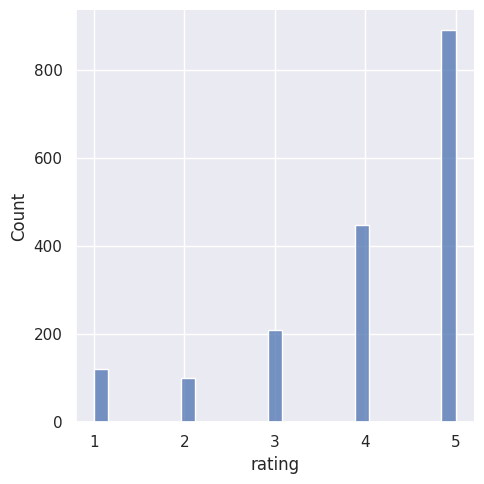

In [12]:
sns.displot(data=df, x='rating');

### Date

In [19]:
df_aux = df.copy()
df_aux['year'] = df['date'].dt.year
df_aux['month'] = df['date'].dt.month

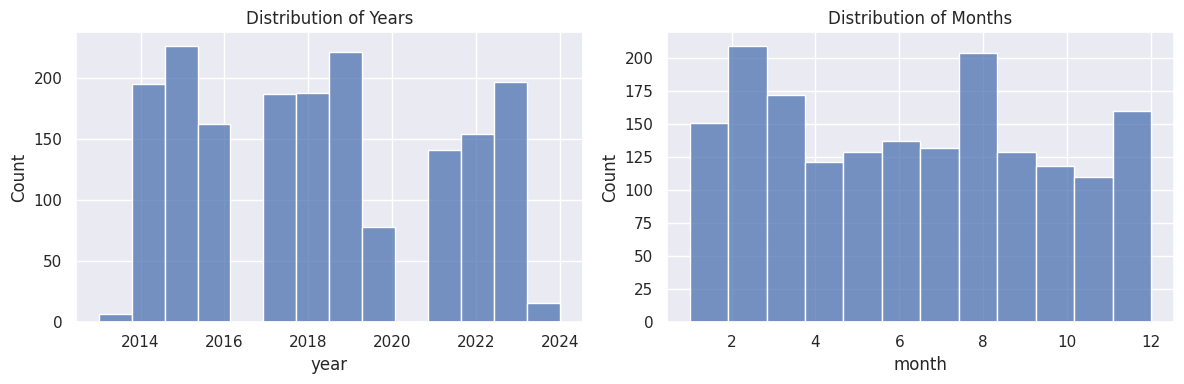

In [56]:
# Definindo o tamanho das figuras
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Barras de Count
sns.histplot(df_aux['year'], ax=axs[0])
axs[0].set_title('Distribution of Years')

# Gráfico 2 - Boxplot de Reason
sns.histplot(df_aux['month'], ax=axs[1])
axs[1].set_title('Distribution of Months')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()



# 2.0 Machine Learnign Modeling

In [155]:
X = df.reset_index()

## 2.1 VADER Model

In [156]:
df_vader = df.copy().reset_index()

In [157]:
# define the model
sia = SentimentIntensityAnalyzer()

In [158]:
# run polarity score on the entire dataset
res = {}
for i, row in tqdm(X.iterrows(), total=len(X)):
    text = row['comment']
    my_id = row['index']
    res[my_id] = sia.polarity_scores(text)

  0%|          | 0/1772 [00:00<?, ?it/s]

In [159]:
# merge predictions to the original df
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index()
vaders = vaders.merge(df_vader, how='left', on='index')
vaders = vaders[['index', 'neg', 'neu', 'pos', 'compound', 'rating', 'comment', 'date']]

### 2.1.1 EDA VADER

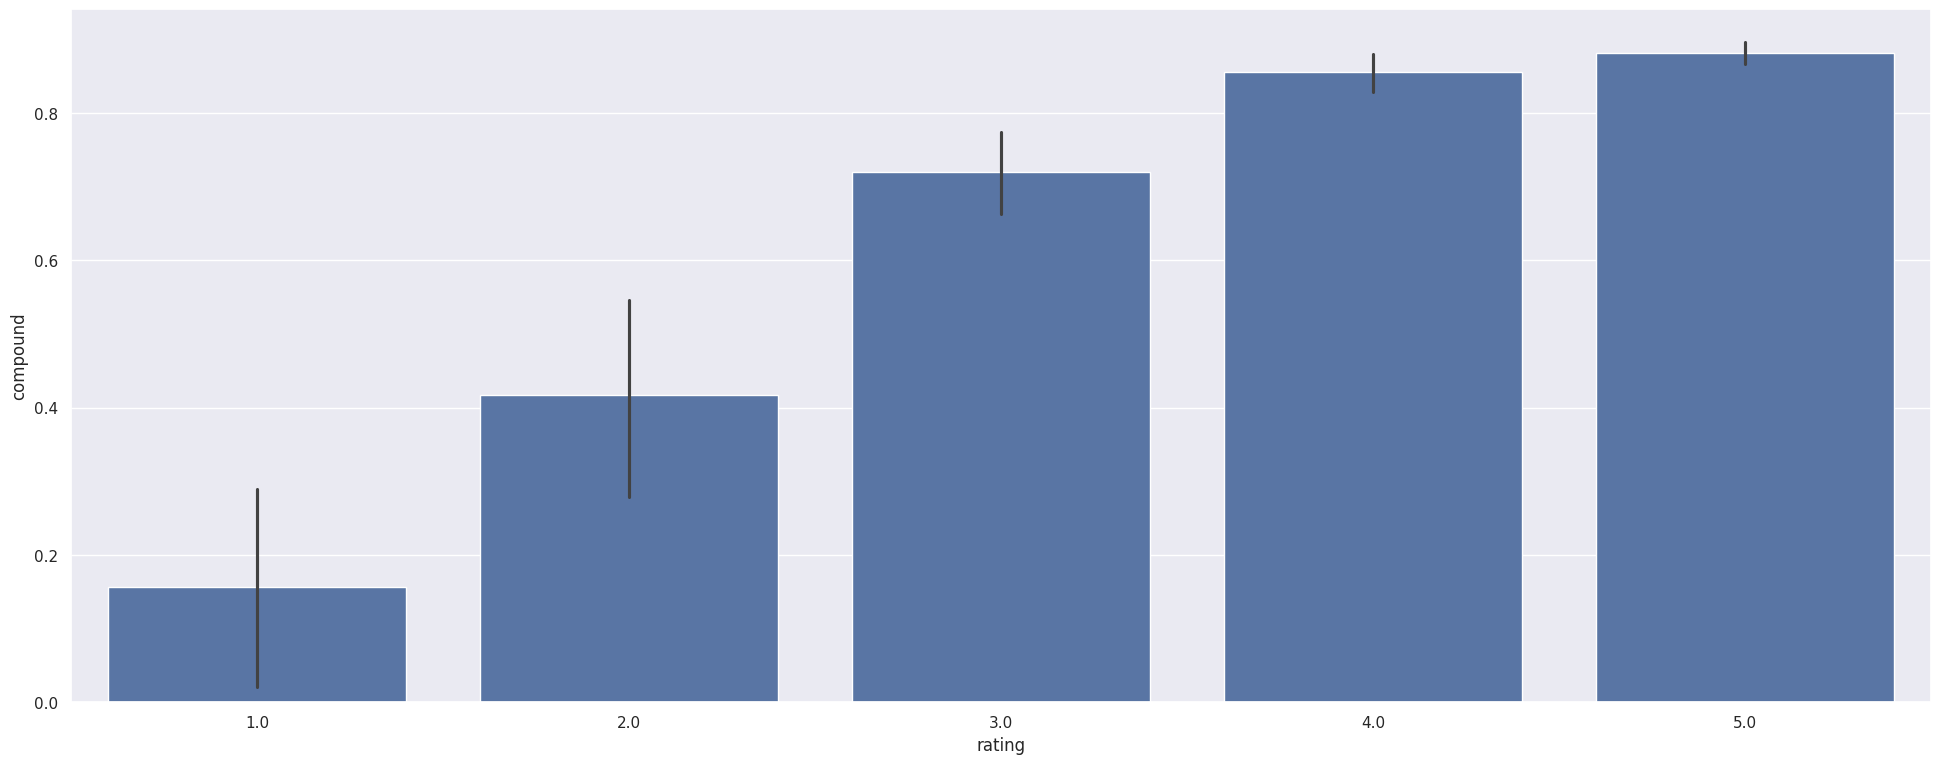

In [69]:
sns.barplot(data=vaders, x='rating', y='compound');

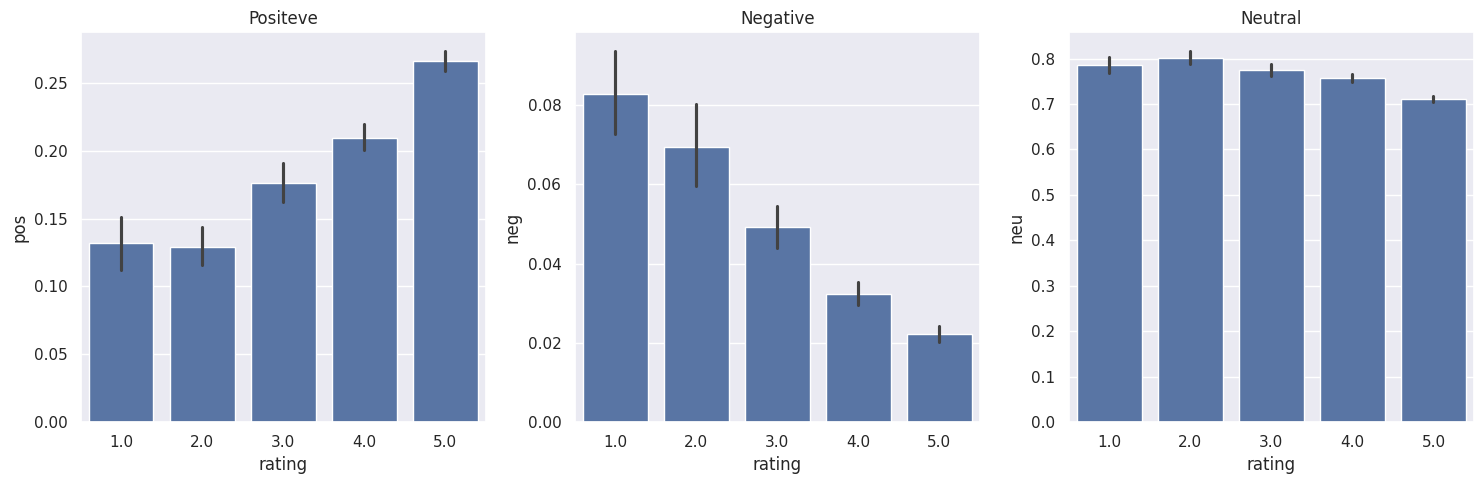

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0]);
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[1]);
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[2]);
axs[0].set_title('Positeve')
axs[1].set_title('Negative')
axs[2].set_title('Neutral')
plt.tight_layout()

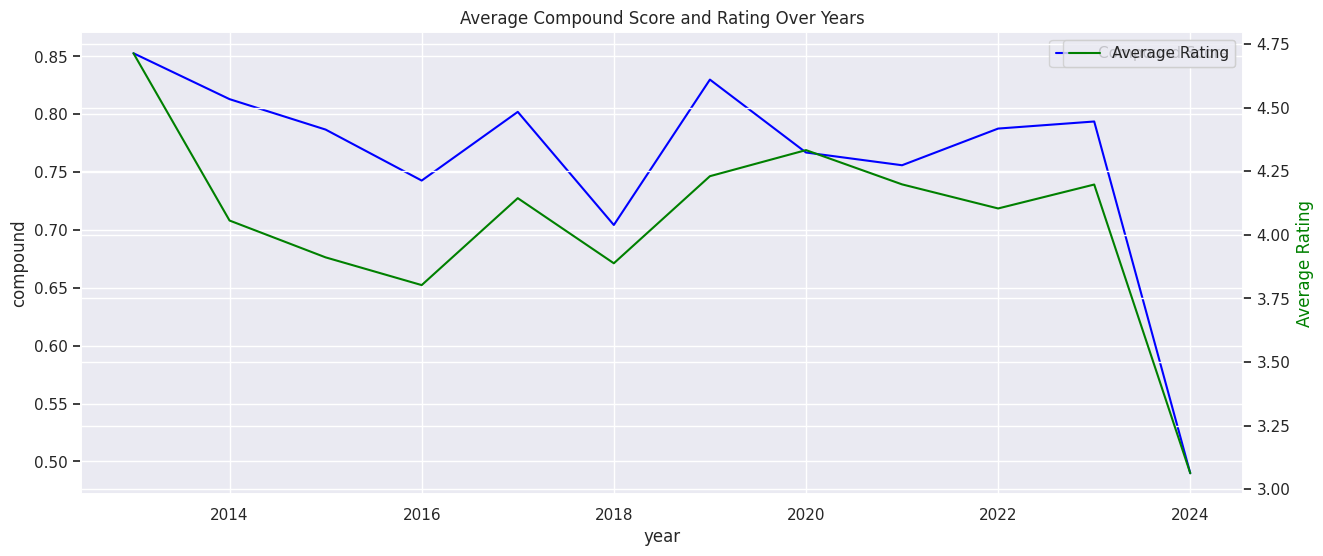

In [160]:
# Assuming df_aux1 is your DataFrame
df_aux1 = vaders.copy()
df_aux1['year'] = df_aux1['date'].dt.year
by_year = df_aux1[['year', 'compound', 'rating']].groupby('year').mean().reset_index()

# Plotting using Seaborn lineplot
plt.figure(figsize=(15, 6))

# Plot Compound Score on the primary y-axis
sns.lineplot(data=by_year, x='year', y='compound', label='Compound Score', color='blue')

# Create a secondary y-axis for Average Rating
ax2 = plt.gca().twinx()
sns.lineplot(data=by_year, x='year', y='rating', label='Average Rating', color='green', ax=ax2)

# Set title and labels
plt.title('Average Compound Score and Rating Over Years')
plt.xlabel('Year')

# Set y-axis labels
plt.ylabel('Compound Score', color='blue')
ax2.set_ylabel('Average Rating', color='green')

# Show legend
plt.legend()

# Show the plot
plt.show()


### Transformers Pipeline

In [195]:
# define model
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [196]:
res = {}
for i, row in tqdm(X.iterrows(), total=len(X)):
    try:
        text = row['comment']
        my_id = row['index']
        
        res[my_id] = sent_pipeline(text)   
    
    except RuntimeError:
        print(f'Broke for id {my_id}')

  0%|          | 0/1772 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors


Broke for id 74
Broke for id 94
Broke for id 170
Broke for id 196
Broke for id 225
Broke for id 280
Broke for id 299
Broke for id 383
Broke for id 411
Broke for id 429
Broke for id 544
Broke for id 578
Broke for id 589
Broke for id 591
Broke for id 611
Broke for id 665
Broke for id 697
Broke for id 699
Broke for id 751
Broke for id 755
Broke for id 815
Broke for id 899
Broke for id 905
Broke for id 930
Broke for id 932
Broke for id 947
Broke for id 957
Broke for id 960
Broke for id 1026
Broke for id 1064
Broke for id 1074
Broke for id 1076
Broke for id 1100
Broke for id 1128
Broke for id 1177
Broke for id 1198
Broke for id 1206
Broke for id 1210
Broke for id 1214
Broke for id 1228
Broke for id 1229
Broke for id 1241
Broke for id 1255
Broke for id 1258
Broke for id 1279
Broke for id 1316
Broke for id 1331
Broke for id 1333
Broke for id 1363
Broke for id 1502
Broke for id 1572
Broke for id 1626
Broke for id 1629
Broke for id 1674
Broke for id 1717
Broke for id 1718
Broke for id 1733
Brok

In [197]:
df_trans = df.copy().reset_index()
data_list = [item[0] for item in res.values()]
df_res = pd.DataFrame(data_list).reset_index()
df_trans = df_trans.merge(df_res, how='left')

### EDA Transformers

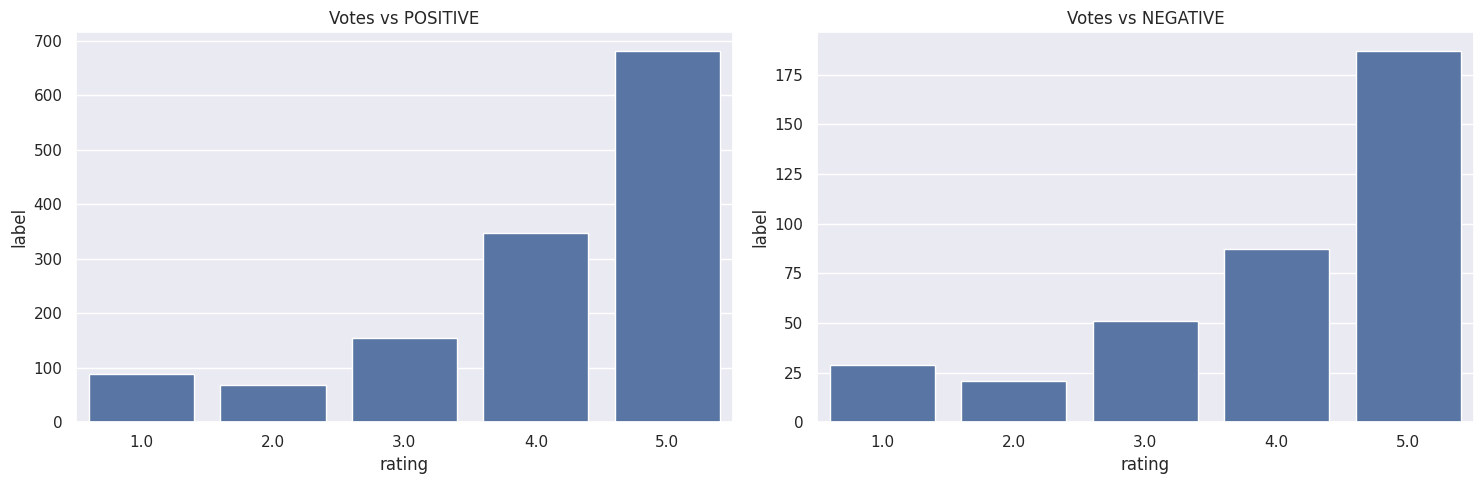

In [164]:
pos = df_trans[df_trans['label'] == 'POSITIVE' ]
neg = df_trans[df_trans['label'] == 'NEGATIVE']

df_pos = pos[['rating', 'label']].groupby('rating').count().reset_index()
df_neg = neg[['rating', 'label']].groupby('rating').count().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data=df_pos, x='rating', y='label', ax=axs[0]);
sns.barplot(data=df_neg, x='rating', y='label', ax=axs[1]);
axs[0].set_title('Votes vs POSITIVE')
axs[1].set_title('Votes vs NEGATIVE')
plt.tight_layout()

In [205]:
# extract the year from date
df_aux1 = df_trans.copy()
df_aux1['year'] = df_aux1['date'].dt.year


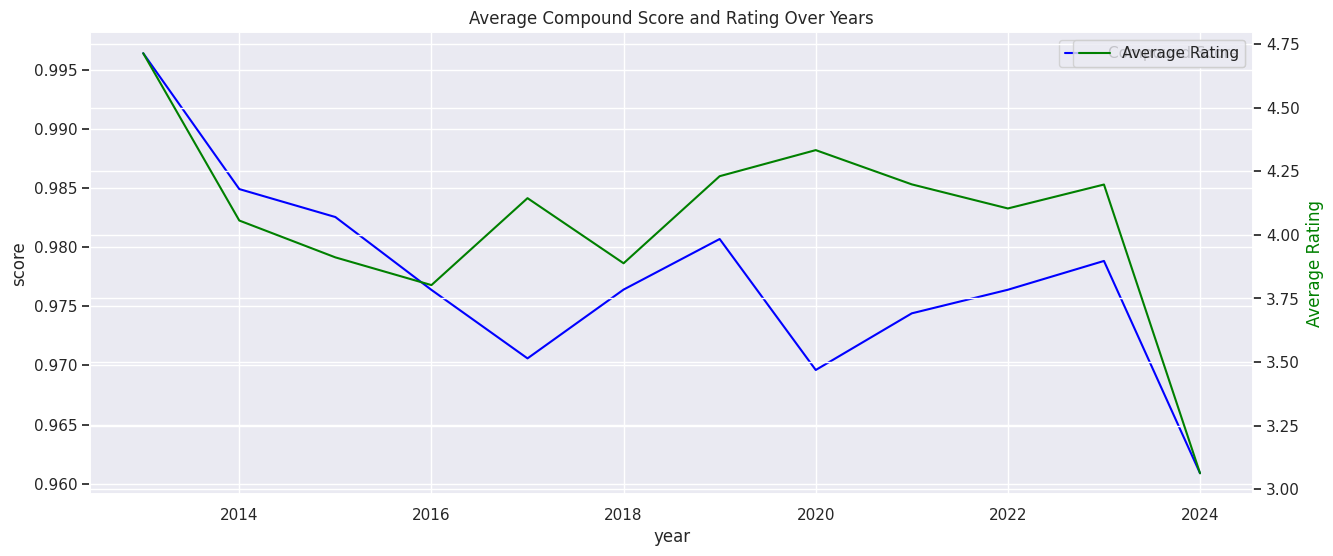

In [175]:
# group by year
by_year = df_aux1[['year', 'score', 'rating']].groupby('year').mean().reset_index()

# Plotting using Seaborn lineplot
plt.figure(figsize=(15, 6))

# Plot Compound Score on the primary y-axis
sns.lineplot(data=by_year, x='year', y='score', label='Compound Score', color='blue')

# Create a secondary y-axis for Average Rating
ax2 = plt.gca().twinx()
sns.lineplot(data=by_year, x='year', y='rating', label='Average Rating', color='green', ax=ax2)

# Set title and labels
plt.title('Average Compound Score and Rating Over Years')
plt.xlabel('Year')

# Set y-axis labels
plt.ylabel('Score', color='blue')
ax2.set_ylabel('Average Rating', color='green')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [244]:

df_pos = df_aux1[df_aux1['label'] == 'POSITIVE']
df_neg = df_aux1[df_aux1['label'] == 'NEGATIVE']

by_label_positive = df_pos[['year', 'label']].groupby('year').count().reset_index()
by_label_positive.columns = ['year', 'positive']

by_label_negative = df_neg[['year', 'label']].groupby('year').count().reset_index()
by_label_negative.columns = ['year', 'negative']

by_label = by_label_positive.merge(by_label_negative, how='left', on='year')

# negative percentage
by_label['negative_%'] = (by_label['negative'] / by_label['positive']) * 100

# selected years
drop_years = [2013, 2024]
mask = ~by_label['year'].isin(drop_years)
by_label = by_label[mask]


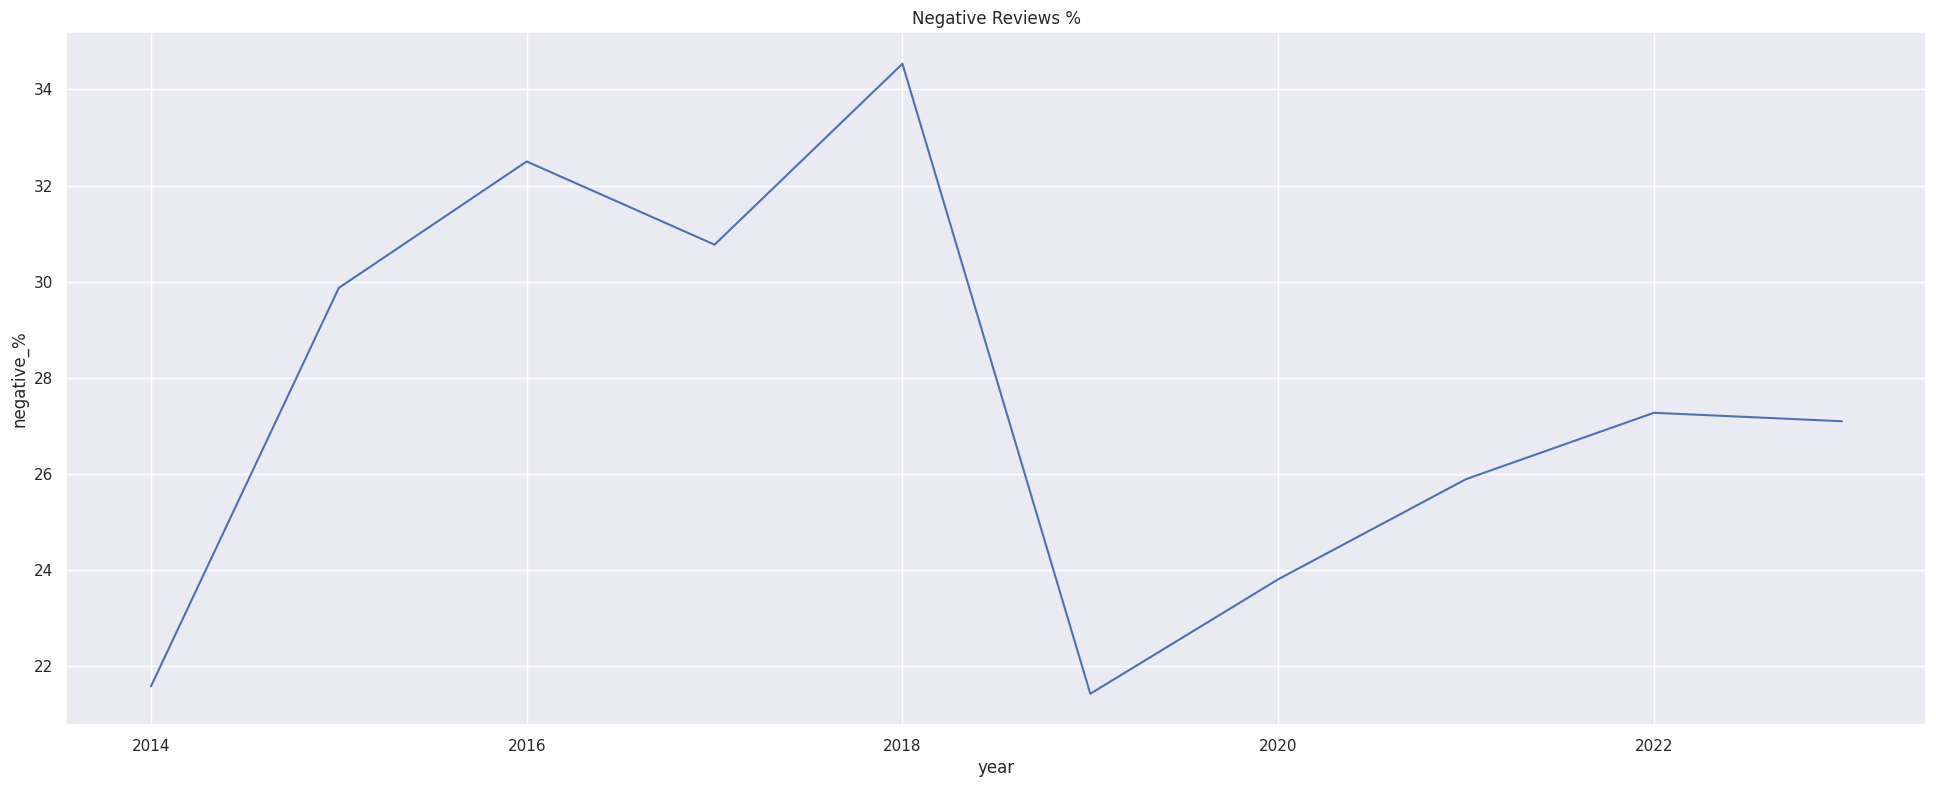

In [247]:
sns.lineplot(by_label, x='year', y='negative_%');
plt.title('Negative Reviews %');

In [239]:
by_label

,year,positive,negative,negative_%
0,2013,2,3,150.000000
1,2014,139,30,21.582734
2,2015,154,46,29.870130
3,2016,120,39,32.500000
4,2017,143,44,30.769231
5,2018,139,48,34.532374
6,2019,182,39,21.428571
7,2020,63,15,23.809524
8,2021,112,29,25.892857
9,2022,121,33,27.272727


### Roberta

In [167]:
# Define the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [168]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [171]:
res = {}
for i, row in tqdm(X.iterrows(), total=len(X)):
    try:
        text = row['comment']
        myid = row['index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1772 [00:00<?, ?it/s]

Broke for id 74
Broke for id 94
Broke for id 170
Broke for id 196
Broke for id 225
Broke for id 280
Broke for id 299
Broke for id 383
Broke for id 411
Broke for id 429
Broke for id 589
Broke for id 591
Broke for id 611
Broke for id 665
Broke for id 697
Broke for id 699
Broke for id 751
Broke for id 755
Broke for id 815
Broke for id 899
Broke for id 905
Broke for id 930
Broke for id 932
Broke for id 947
Broke for id 957
Broke for id 960
Broke for id 1026
Broke for id 1064
Broke for id 1074
Broke for id 1076
Broke for id 1100
Broke for id 1128
Broke for id 1177
Broke for id 1198
Broke for id 1206
Broke for id 1210
Broke for id 1214
Broke for id 1228
Broke for id 1229
Broke for id 1241
Broke for id 1255
Broke for id 1258
Broke for id 1279
Broke for id 1316
Broke for id 1331
Broke for id 1333
Broke for id 1502
Broke for id 1549
Broke for id 1572
Broke for id 1626
Broke for id 1629
Broke for id 1674
Broke for id 1717
Broke for id 1718
Broke for id 1733
Broke for id 1765


In [172]:
df1 = df.copy().reset_index()
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index()
results_df = results_df.merge(df1, how='left')

In [173]:
results_df.head()

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,comment,rating,date
0,0,0.018,0.793,0.189,0.9973,0.017475,0.094942,0.887583,I came here this passed Sunday for brunch. We ...,5.0,2024-01-31
1,1,0.015,0.702,0.283,0.9990,0.006055,0.048760,0.945185,I came here last night and I must say I was un...,4.0,2022-04-08
2,2,0.000,0.806,0.194,0.9842,0.011154,0.081553,0.907293,- super large venue- they have it down to a sc...,4.0,2023-12-08
3,3,0.034,0.938,0.028,0.1114,0.916582,0.075806,0.007611,We made a reservation for thanksgiving at 5:45...,1.0,2023-11-24
4,4,0.020,0.696,0.284,0.9442,0.044058,0.392043,0.563899,You should always be seated at your reservatio...,5.0,2024-01-16
